# Solution: Modelling treatment

**Exentending the SIR model to model a treatment which speeds up recovery:**

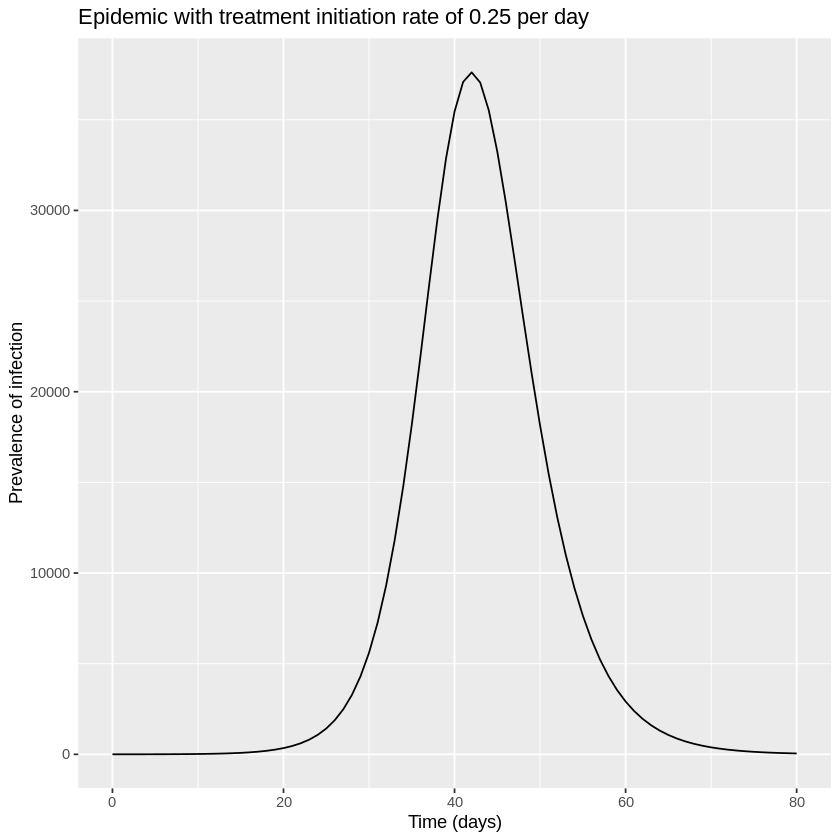

In [1]:
# LOAD THE PACKAGES:
library(deSolve)
library(reshape2)
library(ggplot2)

# MODEL INPUTS:

# Initial number of people in each compartment
initial_state_values <- c(S = 300000,         
                          I = 1,           
                          R = 0,          
                          T = 0)   # treatment compartment: no one is on treatment at the beginning of the simulation

# Parameters describing the transition rates in units of days^-1
parameters <- c(beta = 0.6,       # the infection rate
                gamma = 0.2,      # the natural (untreated) rate of recovery
                h = 0.25,         # the rate of treatment initiation
                gamma_t = 0.8)    # the rate of recovery after treatment

# TIMESTEPS:

# Sequence of timesteps to solve the model at
times <- seq(from = 0, to = 80, by = 1)   # from 0 to 80 days in daily intervals

# MODEL FUNCTION: 

treatment_model <- function(time, state, parameters) {  

    with(as.list(c(state, parameters)), {    
        
    # Calculating the total population size N 
      N <- S+I+R+T                          # need to add the treated compartment here
      
    # Defining lambda
      lambda <- beta * (I+T)/N              # force of infection depends on the proportion in the I and T compartment  
        
    # The differential equations
      dS <- -lambda * S            
      dI <- lambda * S - gamma * I - h * I  # infected people initiate treatment at a rate h  
      dT <- h * I - gamma_t * T             # people enter the treated compartment at rate h and recover at rate gamma_t
      dR <- gamma * I + gamma_t * T         # movement into the recovered compartment is from infected and treated compartment
      
    # Return the number of people in each compartment at each timestep 
    # (in the same order as the input state variables)
    return(list(c(dS, dI, dR, dT)))          # need to add the rate of change in the treated compartment T here
    })
  
}

# MODEL OUTPUT:

# Solving the differential equations using the ode integration algorithm
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = treatment_model,
                            parms = parameters))

# Plot the number infected
ggplot(data = output,                                               
       aes(x = time, y = I+T)) +                  # infected people include those untreated (I) and treated (T)
  geom_line() +                                                          
  xlab("Time (days)")+                                                   
  ylab("Prevalence of infection") +                                      
  labs(title = paste("Epidemic with treatment initiation rate of", parameters["h"], "per day"))

### How many people are infected at the peak of the epidemic?

At the peak of the epidemic around 37600 are infected - this includes the I as well as the T (treated) compartment.

**Increasing the treatment initiation rate to interrupt transmission (reduce R<sub>0</sub> below 1):**

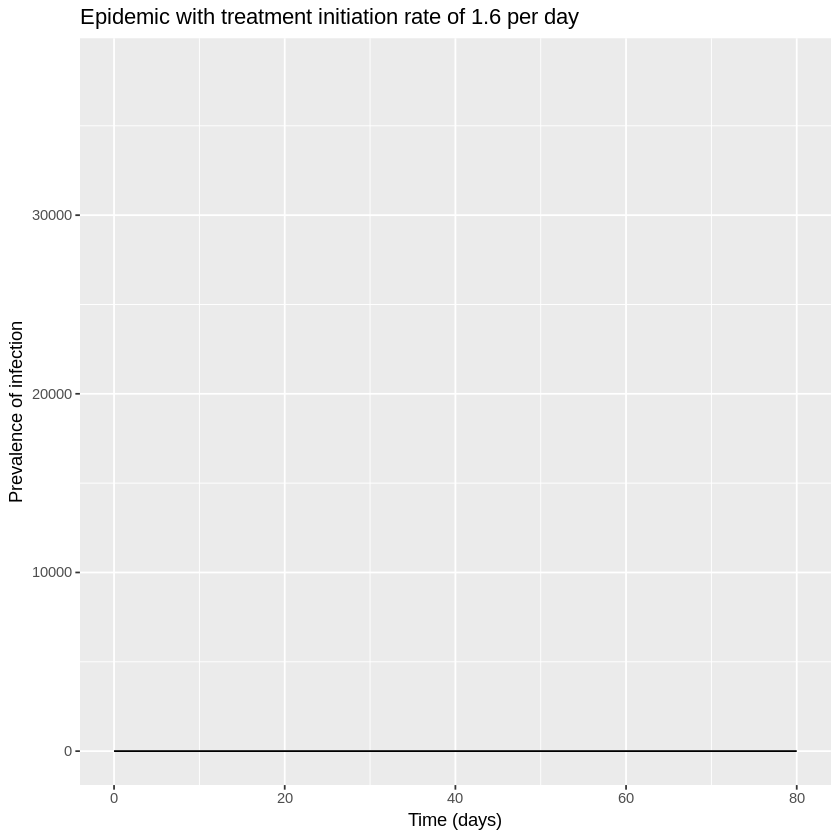

In [2]:
# Increase the treatment initiation rate
parameters["h"] <- 1.6

# Simulate the model
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = treatment_model,
                            parms = parameters))

# Plot the number infected (I+T compartments)
ggplot(data = output,                                               
       aes(x = time, y = I+T)) +                
  geom_line() +                                                          
  xlab("Time (days)")+                                                   
  ylab("Prevalence of infection") +                                      
  labs(title = paste("Epidemic with treatment initiation rate of", parameters["h"], "per day")) +
  ylim(c(0,38000))                    # for visual purposes add the same limit on the y axis as on previous plot

# If you look at the numbers infected or remove the limit on the y axis, you will see that with h = 1.6, 
# the number of infected people never rises up to 2, in comparison to h = 1.5 for example. 

### How rapidly does treatment need to be initiated in order to interrupt transmission, i.e. to bring R<sub>0</sub> below 1? Based on this, do you think it is feasible to interrupt transmission through treatment alone?

To interrupt transmission by bringing R<sub>0</sub> below 1, the treatment initiation rate needs to be at least 1.6 per day, which means people need to start treatment less than a day after becoming infected on average. 

To achieve a reduction in the treatment initiation rate, think about what it depends on: the time it takes people to go to a doctor, the time it takes to get a diagnosis, and the time from diagnosis to starting treatment for example. These in turn depend on many situational aspects such as whether the disease is symptomatic, the healthcare system, which test is required for a diagnosis etc. One way of increasing the rate of treatment initiation would be through active case-finding for example, rather than waiting for people to seek medical attention themselves. 

However, given all these factors, achieving a treatment initiation rate as high as required in this example does not seem feasible.

### Using only reasoning based on R<sub>0</sub> (i.e. without computer simulation), what is the minimum value of *h* needed to interrupt transmission? Is this consistent with what you found using the model in the previous question?

Remember that R<sub>0</sub> is defined as the average number of secondary infections caused by a single infectious case (in a totally susceptible population). We can derive the following equation:

\begin{align}
R_0 & = \frac{\beta}{\gamma+h} + \frac{h}{\gamma+h} \times \frac{\beta}{\gamma_T}
\end{align}

Here, we are taking the average of secondary infections caused by index cases in the I and the T compartment, keeping in mind that only a proportion \begin{align} \frac{h}{\gamma+h}\end{align} move into the treatment compartment before recovering.

Solving this equation with our parameter values to obtain R<sub>0</sub> < 1:

\begin{align}
1 & > \frac{0.6}{0.2+h} + \frac{h}{0.2+h} \times \frac{0.6}{0.8} \\
0.2 + h & > 0.6 + 0.75 h \\
h & > 1.6
\end{align}

This is consistent with the value we found with the model in the previous question!


### What other (theoretical) changes could you make to this treatment to improve its impact on the epidemic?

In reality, the delay between people becoming infected and people starting on treatment is often the only thing that can be changed to some degree during an outbreak. However, given more time, improving the efficacy and biological action of the treatment itself is likely to improve its impact on reducing the prevalence, for example by:
- increasing the recovery rate of those on treatment
- developing a treatment that additionally reduces the infectiousness of those who take it

Keep in mind though that how the efficacy of a treatment translates into its population-level impact is not always obvious, and depends again on many other factors.